<a href="https://colab.research.google.com/github/Chiru-CatalinMihail/CollegeProjects/blob/main/Automatic_translation_of_a_person_voice_in_a_foreign_language_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center> Automatic translation of a person voice in a foreign language - Translatotron 2 architecture </center>

<font size= "3">
    <p style='text-align: right;'> 
        <b> Guiding Professor: </b> Associate Professor, Dr. Traian Rebedea <br>
        <b> Student: </b> Catalin-Mihail Chiru <br>
        <b> Group: </b> 342C4
    </p>
</font>

Code for extracting files from Google Drive taken from:

https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

https://colab.research.google.com/github/sudo-ken/compress-decompress-in-Google-Drive/blob/master/Unrar_Unzip_Rar_Zip_in_GDrive.ipynb#scrollTo=TfWtGXmqbggL

In [1]:
!pip install -U -q PyDrive
!pip install tensorflow-io
!pip install numpy
!pip install librosa
!pip install torchaudio #==0.6.0
!pip install sentencepiece
!pip install pytorch-lightning
!pip install hydra-core --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 80.7 MB/s 
     |████████████████████████████████| 419 kB 90.4 MB/s 
     |████████████████████████████████| 140 kB 94.7 MB/s 
     |████████████████████████████████| 1.1 MB 81.6 MB/s 
  

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import os

import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import soundfile as sf

In [3]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#@markdown <br><center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Google_Drive_logo.png/600px-Google_Drive_logo.png' height="50" alt="Gdrive-logo"/></center>
#@markdown <center><h3>Mount GDrive to /content/drive</h3></center><br>
MODE = "MOUNT" #@param ["MOUNT", "UNMOUNT"]
#Mount your Gdrive! 
from google.colab import drive
drive.mount._DEBUG = False
if MODE == "MOUNT":
  drive.mount('/content/drive/', force_remount=True)
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass
  get_ipython().system_raw("rm -rf /root/.config/Google/DriveFS")

# corpus_link = 'https://drive.google.com/drive/folders/1m2ziJL_U-UVeuKpbsUtvNGbm6NSSBkXY?usp=sharing'

# fluff, id = corpus_link.split('=')

# print(id)

Mounted at /content/drive/


In [4]:
english_corpus_path = '/content/drive/MyDrive/Licenta/cvss_t_es_en_target/'

english_train_path = english_corpus_path + 'train/'
english_dev_path = english_corpus_path + 'dev/'
english_test_path = english_corpus_path + 'test/'


spanish_corpus_path = '/content/drive/MyDrive/Licenta/cv-corpus-9.0-2022-04-27-es/'

spanish_matching_path = spanish_corpus_path + 'matching/'

spanish_matching_train_path = spanish_matching_path + 'train/'
spanish_matching_dev_path = spanish_matching_path + 'dev/'
spanish_matching_test_path = spanish_matching_path + 'test/'

spanish_1_path = spanish_corpus_path + '1/'
spanish_2_path = spanish_corpus_path + '2/'
spanish_3_path = spanish_corpus_path + '3/'
spanish_4_path = spanish_corpus_path + '4/'
spanish_5_path = spanish_corpus_path + '5/'


In [5]:
def extract_just_files(path):
  files = os.listdir(path)

  # The second condition in the if statement is necessary because the Drive is poisoned with copies, and they are distinguishable by the (number) attribute
  extracted_files = [path + f for f in files if os.path.isfile(os.path.join(path, f)) and "(" not in f]
  return extracted_files

In [10]:
english_aux_files = extract_just_files(english_corpus_path)

english_train_files = extract_just_files(english_train_path)
english_dev_files = extract_just_files(english_dev_path)
english_test_files = extract_just_files(english_test_path)

In [11]:
print(len(english_aux_files))
print(len(set(english_train_files)))
print(len(english_dev_files))
print(len(english_test_files))

4
79012
13212
13216


In [15]:
spanish_aux_files = extract_just_files(spanish_corpus_path)

spanish_matched_train_files = extract_just_files(spanish_matching_train_path)
spanish_matched_dev_files = extract_just_files(spanish_matching_dev_path)
spanish_matched_test_files = extract_just_files(spanish_matching_test_path)

In [16]:
print(len(spanish_aux_files))
print(len(spanish_matched_train_files))
print(len(spanish_matched_dev_files))
print(len(spanish_matched_test_files))

7
79010
13212
13216


In [18]:
spanish_unmatched_files = extract_just_files(spanish_1_path) \
            + extract_just_files(spanish_2_path)  + extract_just_files(spanish_3_path) \
            + extract_just_files(spanish_4_path) + extract_just_files(spanish_5_path)

In [19]:
print(len(spanish_unmatched_files))

430994


For melspectrogramms:

Librosa:
https://importchris.medium.com/how-to-create-understand-mel-spectrograms-ff7634991056 (9 June 2022)

Tensorflow:
https://www.tensorflow.org/io/tutorials/audio (9 June 2022)



sr = sample_rate (based on Translatotron 2 paper I have chosen the maximum among inputs = 48kHz)

In [98]:
# Librosa approach
def generate_melspectro(audio_file_path, sample_rate, mels=400): #, mel_min=125, mel_max=7600 samples_per_windows, samples_stride, 
  signal, sr = librosa.load(audio_file_path, sr=sample_rate)

  # All the characteristics are taken from Translatotron2 table of hyper-parameters pag 13/15
  mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=mels) #, fmin=mel_min, fmax=mel_max, ,  hop_length=samples_stride, n_fft=samples_per_windows)
  spectrogram = np.abs(mel_signal)

  return (signal, spectrogram, sr)

def plot_spectro(signal, sr):
  plt.figure(figsize=(20, 5))
  librosa.display.waveplot(signal, sr=sr)
  plt.title('Waveplot', fontdict=dict(size=18))
  plt.xlabel('Time', fontdict=dict(size=15))
  plt.ylabel('Amplitude', fontdict=dict(size=15))
  plt.show()
  return

def plot_melspectro(spectrogram, sr, samples_stride):
  power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
  plt.figure(figsize=(8, 7))
  librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma') 
  #, hop_length=samples_stride)
  plt.colorbar(label='dB')
  plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
  plt.xlabel('Time', fontdict=dict(size=15))
  plt.ylabel('Frequency', fontdict=dict(size=15))
  plt.show()
  plt.cla()
  plt.clf()
  return

def generate_wavfile(path, name, spectrogram, sample_rate, samples_per_windows=2048, samples_stride=512):
  # step3 converting mel-spectrogrma back to wav file
  res = librosa.feature.inverse.mel_to_audio(spectrogram, 
                                            sr=sample_rate, 
                                            n_fft=samples_per_windows, 
                                            hop_length=samples_stride, 
                                            win_length=None, 
                                            window='hann', 
                                            center=True, 
                                            pad_mode='reflect', 
                                            power=2.0, 
                                            n_iter=32)

  # step4 - save it as a wav file
  sf.write(path + name, res, sample_rate)
  return


In [121]:
corpus_sample_path = spanish_matched_train_files[spanish_matched_train_files.index('/content/drive/MyDrive/Licenta/cv-corpus-9.0-2022-04-27-es/matching/train/common_voice_es_18674060.mp3')]
corpus_sample_path

'/content/drive/MyDrive/Licenta/cv-corpus-9.0-2022-04-27-es/matching/train/common_voice_es_18674060.mp3'

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


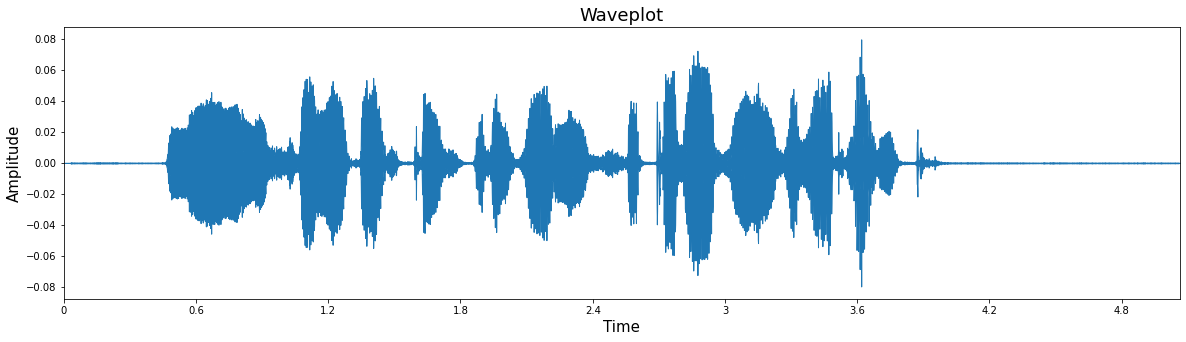

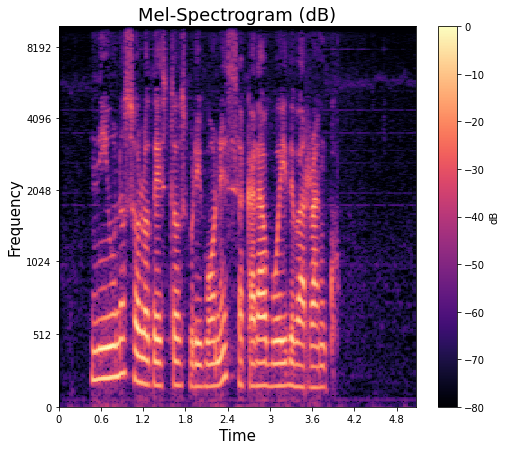

<Figure size 432x288 with 0 Axes>

In [122]:
# sample_rate was 48000
(signal, spectrogram, sr) = generate_melspectro(corpus_sample_path, 20000) #, 8192, 256)
plot_spectro(signal, sr)
plot_melspectro(spectrogram, sr, 256)


In [123]:
generate_wavfile(english_corpus_path, "surfers_audio.wav", spectrogram, sr)

In [112]:
ll $english_corpus_path

total 8820
drwx------ 2 root    4096 Jun 16 17:41 dev/
-rw------- 1 root 1153894 Jun 16 17:26 dev.tsv
-rw------- 1 root  128044 Jun 26 18:04 surfers_audio.wav
drwx------ 2 root    4096 Jun 16 20:02 test/
-rw------- 1 root 1152713 Jun 16 17:26 test.tsv
drwx------ 2 root    4096 Jun 16 22:06 train/
-rw------- 1 root 6583419 Jun 16 17:26 train.tsv
